In [64]:
# import
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()


from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering,AffinityPropagation,SpectralClustering
from sklearn import preprocessing
from sklearn import metrics
import datetime
from datetime import datetime
import time

In [65]:
# seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [66]:
# data
# df=pd.read_csv('/content/Батч 1.xlsx')

# batch_nornal - предобработанный бач данных, с нужными фичами
df=pd.read_csv('/content/Batch_normal.csv',parse_dates=True)
df=df.iloc[:30000,:]
data_property=['untreated','normal']
flag=data_property[1]
if df.shape[1]==26:
  flag=data_property[1]

In [67]:
# df2=pd.read_csv('/content/select_p_hid_p_dt_p_sender_index_p_re (1).csv')

In [68]:
# df_2=pd.read_excel('/content/select_p_hid_p_dt_p_sender_index_p_re (1).csv',parse_dates=True)

In [69]:
df.head(n=5)

,Unnamed: 0,Unnamed: 0.1,hid,data,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
0,0,0,17279630-2e29-4a0d-8f96-f3c932e6bbcb,2020-07-05 00:00:26.036,109469,107241,100.0,173.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1593907226,173.0,3,1593908483,173,519.0,0.574012,0.589201
1,1,1,16971e43-728a-4f66-a93c-3678aa8433cd,2020-07-05 00:03:17.229,390039,125284,1100.0,238.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1593907397,238.0,1,1593907397,238,238.0,0.177506,0.530563
2,2,2,16d739fa-ca72-4b12-b8a1-ae5d91df945f,2020-07-05 00:11:47.671,111250,670033,100.0,173.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1593907907,183.5,2,1593979001,183,367.0,18.310989,0.591362
3,3,3,8182829,2020-07-05 00:12:50.965,105173,183035,2262.0,363.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907970,311.0,4,1593947921,311,1244.0,10.313781,0.774597
4,4,4,1645b790-f6f9-4c3f-b92b-eae34e781784,2020-07-05 00:13:05.474,195197,184209,1905.0,338.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907985,313.0,2,1593907985,313,626.0,0.142772,0.709614


In [70]:
# Подготовка данных, если загружаются сырые данные
if flag=='untreated':
  df.rename(columns={'дата оформления': 'data', 'индекс отправителя': 'sender_index',
                   'индекс получателя': 'recipient_index','вес (гр)': 'weight','стоимость (руб,коп)': 'cost',
                   'сумма ОЦ (руб)': 'summa_OTS', 'сумма НП (руб)':'summa_NP',
                   'безбланковая отправка':'blank_dispatch','бандероль':'parcel_post',
                   'ускоренное':'accelerated','международное':'international','с объявл. ценностью':'with_advert_value',
                   'с налож. платежом':'with_imposition_payment','с описью вложений':'with_list_of_attachments',
                   "отметка 'Осторожно'":'caution_mark','sms для отправителя':'sms for sender','sms для получателя':'sms for recipient'}, inplace=True)
  df=df.fillna(0)
  df["blank_dispatch"] = df["blank_dispatch"].astype(int)
  df["parcel_post"] = df["parcel_post"].astype(int)
  df["accelerated"] = df["accelerated"].astype(int)
  df["international"] = df["international"].astype(int)
  df["with_advert_value"] = df["with_advert_value"].astype(int)
  df["with_imposition_payment"] = df["with_imposition_payment"].astype(int)
  df["with_list_of_attachments"] = df["with_list_of_attachments"].astype(int)
  df["caution_mark"] = df["caution_mark"].astype(int)
  df["sms for sender"] = df["with_imposition_payment"].astype(int)
  df["sms for recipient"] = df["sms for recipient"].astype(int)
  df['data'] = pd.to_datetime(df['data'], errors='coerce')
  df['ts'] = df.data.values.astype(np.int64) // 10 ** 9
  df['mean_user_cost']=''
  df['count_sum']=''
  df['max_data']=''
  df['ts_delta']=''
  df['sum_cost']=''


In [71]:
if flag=='untreated':
  dict_count=df.groupby(['hid'])['data'].count().to_dict()
  dict_max_data=df.groupby(['hid'])['ts'].apply(list).apply(np.max).to_dict()
  dict_ts_delta=df.groupby('hid')['cost'].apply(list).apply(np.mean).apply(np.mean).to_dict()
  dict_mean_cost=df.groupby('hid')['cost'].apply(list).apply(np.mean).to_dict()
  dict_sum_cost=df.groupby('hid')['cost'].apply(list).apply(np.sum).to_dict()
  iter=0
  for i in df.hid:
    df.loc[df['hid']==i,'mean_user_cost']=dict_mean_cost[i]
    df.loc[df['hid']==i,'count_sum']=dict_count[i]
    df.loc[df['hid']==i,'max_data']=dict_max_data[i]
    df.loc[df['hid']==i,'ts_delta']=dict_ts_delta[i]
    df.loc[df['hid']==i,'sum_cost']=dict_sum_cost[i]
    iter+=1
    print(iter)
  df=df.replace('',0)
  df["mean_user_cost"] = df["mean_user_cost"].astype(float)
  df["count_sum"] = df["count_sum"].astype(int)
  df["max_data"] = df["max_data"].astype(int)
  df["ts_delta"] = df["ts_delta"].astype(int)
  df["sum_cost"] = df["sum_cost"].astype(float)


In [72]:
# создание метрик
# if flag=='untreated':
df['activity'] = df.count_sum/df.count_sum.mean() + df.ts_delta.mean()/df.ts_delta + ((df.max_data-df.ts)/df.ts_delta.mean())
df['solvency']=df.sum_cost/df.sum_cost.mean()+df.mean_user_cost/df.mean_user_cost.mean()+df.accelerated*0.2+df.with_advert_value+0.1+df.with_imposition_payment*0.1
max_act=df['activity'].max()
max_solv=df['solvency'].max()
df['activity']=df['activity']/max_act*100

df['solvency']=df['solvency']/max_solv*10

In [73]:
df.mean_user_cost.mean()

400.6803136666656

In [74]:
df.solvency.max()

10.0

In [75]:
df.activity.max()

100.0

In [76]:
df.head()

,Unnamed: 0,Unnamed: 0.1,hid,data,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
0,0,0,17279630-2e29-4a0d-8f96-f3c932e6bbcb,2020-07-05 00:00:26.036,109469,107241,100.0,173.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1593907226,173.0,3,1593908483,173,519.0,0.574012,0.589201
1,1,1,16971e43-728a-4f66-a93c-3678aa8433cd,2020-07-05 00:03:17.229,390039,125284,1100.0,238.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1593907397,238.0,1,1593907397,238,238.0,0.177506,0.530563
2,2,2,16d739fa-ca72-4b12-b8a1-ae5d91df945f,2020-07-05 00:11:47.671,111250,670033,100.0,173.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,1593907907,183.5,2,1593979001,183,367.0,18.310989,0.591362
3,3,3,8182829,2020-07-05 00:12:50.965,105173,183035,2262.0,363.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907970,311.0,4,1593947921,311,1244.0,10.313781,0.774597
4,4,4,1645b790-f6f9-4c3f-b92b-eae34e781784,2020-07-05 00:13:05.474,195197,184209,1905.0,338.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1593907985,313.0,2,1593907985,313,626.0,0.142772,0.709614


In [77]:
df.cost.sum()

12020409.41

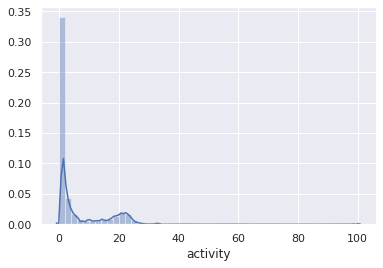

In [78]:
sns_plot = sns.distplot(df['activity'])
fig = sns_plot.get_figure()

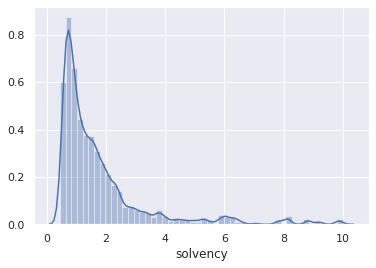

In [79]:
sns_plot = sns.distplot(df['solvency'])
fig = sns_plot.get_figure()

In [80]:
# Описание всего датасета
df.describe()

,Unnamed: 0,Unnamed: 0.1,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,14999.500000,378434.472200,413138.978367,1778.872267,400.680314,676.895033,575.976767,0.718533,0.0,0.181933,0.0,0.261367,0.142567,0.009933,0.004400,0.142567,0.093067,1.593997e+09,400.680314,16.178733,1.594013e+09,400.338600,6543.374654,4.423390,1.752174
std,8660.398374,8660.398374,207352.807352,201571.990938,2649.349722,270.425535,1914.970235,1792.621965,0.449722,0.0,0.385796,0.0,0.439387,0.349636,0.099172,0.066188,0.349636,0.290531,3.716182e+04,210.162520,29.071594,3.295150e+04,210.109513,12073.829355,7.742913,1.591505
min,0.000000,0.000000,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,0.014201,0.445905
25%,7499.750000,7499.750000,153038.000000,196233.000000,300.000000,263.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593961e+09,275.000000,2.000000,1.593989e+09,275.000000,792.000000,0.176785,0.784422
50%,14999.500000,14999.500000,367014.000000,400082.000000,800.000000,313.120000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594016e+09,343.733333,6.000000,1.594029e+09,343.000000,2102.130000,0.566716,1.229042
75%,22499.250000,22499.250000,620076.500000,628611.000000,2000.000000,457.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594030e+09,472.615385,15.000000,1.594034e+09,472.000000,5894.400000,3.440317,1.994617
max,29999.000000,29999.000000,694910.000000,694923.000000,20000.000000,5152.800000,45350.000000,45350.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.594301e+09,5152.800000,177.000000,1.594301e+09,5152.000000,72182.390000,100.000000,10.000000


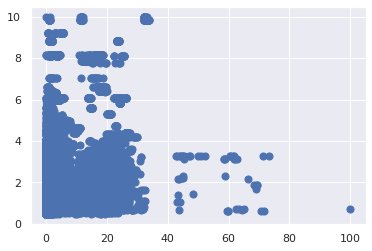

In [81]:
plt.scatter(df.loc[:, 'activity'], df.loc[:, 'solvency'], s = 50);
plt.show()

In [82]:
df.sum_cost.sum()

196301239.63

In [83]:
if flag=='untreated':
  df.to_csv('/content/Batch_normal.csv')

In [84]:
X_sourse=df.iloc[:30000,4:28]
# X_sourse=df.iloc[:10000,[4,5,6,7,8,9,10,23,22,21,20,19]]
# std and norl
# X_sourse=X_sourse.drop('ts',axis=1)
# X_sourse=X_sourse.drop('max_data',axis=1)
X = preprocessing.scale(X_sourse)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [85]:
X_sourse.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,378434.472200,413138.978367,1778.872267,400.680314,676.895033,575.976767,0.718533,0.0,0.181933,0.0,0.261367,0.142567,0.009933,0.004400,0.142567,0.093067,1.593997e+09,400.680314,16.178733,1.594013e+09,400.338600,6543.374654,4.423390,1.752174
std,207352.807352,201571.990938,2649.349722,270.425535,1914.970235,1792.621965,0.449722,0.0,0.385796,0.0,0.439387,0.349636,0.099172,0.066188,0.349636,0.290531,3.716182e+04,210.162520,29.071594,3.295150e+04,210.109513,12073.829355,7.742913,1.591505
min,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,0.014201,0.445905
25%,153038.000000,196233.000000,300.000000,263.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593961e+09,275.000000,2.000000,1.593989e+09,275.000000,792.000000,0.176785,0.784422
50%,367014.000000,400082.000000,800.000000,313.120000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594016e+09,343.733333,6.000000,1.594029e+09,343.000000,2102.130000,0.566716,1.229042
75%,620076.500000,628611.000000,2000.000000,457.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594030e+09,472.615385,15.000000,1.594034e+09,472.000000,5894.400000,3.440317,1.994617
max,694910.000000,694923.000000,20000.000000,5152.800000,45350.000000,45350.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.594301e+09,5152.800000,177.000000,1.594301e+09,5152.000000,72182.390000,100.000000,10.000000


In [86]:
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [87]:
# если не жалко время, то можно и этот метод
#  t-SNE and PCA
# tsne = TSNE(random_state=17)
# X_tsne = tsne.fit_transform(X)

In [88]:
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 50);
# plt.show()

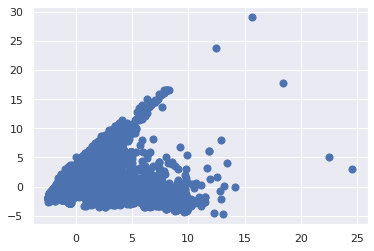

In [89]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 50);
plt.show()

In [90]:
# algoritms
# подбор алгоритма  и сравнение их
# algorithms = []
# algorithms.append(KMeans(n_clusters = 2,n_init = 100,random_state=17 ))
# algorithms.append(AgglomerativeClustering(n_clusters = 2))
# algorithms.append(SpectralClustering(n_clusters=2, random_state=1,
#                                      affinity='nearest_neighbors'))
# # algorithms.append(DBSCAN(eps=0.1, min_samples=5))
# # algorithms.append(AffinityPropagation())

# data = []
# for algo in algorithms:
#     algo.fit(X)
#     print(algo)
#     data.append(({
#         # 'ARI': metrics.adjusted_rand_score(y, algo.labels_),
#         # 'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
#         # 'Homogenity': metrics.homogeneity_score(y, algo.labels_),
#         # 'Completeness': metrics.completeness_score(y, algo.labels_),
#         # 'V-measure': metrics.v_measure_score(y, algo.labels_),
      
#         'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
# results = pd.DataFrame(data=data, columns=['Silhouette'], index=['K-means', 'Agglomerative','Spectral'])
# results

In [91]:
#  подбор оптимального количества сегментов
# loss=[]
# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k,n_init = 100,random_state=1).fit(X)
#     loss_current=metrics.silhouette_score(X, kmeans.labels_)
#     loss.append(loss_current)

# plt.plot(range(2, 10), loss, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('$J(C_k)$');

In [92]:
#  обучение моделей
kmeans = KMeans(n_clusters = 3,n_init = 100,random_state=17 ).fit(X)
# sc = SpectralClustering(n_clusters=3, random_state=1, affinity='nearest_neighbors').fit(X)
# ac2 = AgglomerativeClustering(n_clusters = 3).fit(X)
# clustering = DBSCAN(eps=0.1, min_samples=5).fit(X)

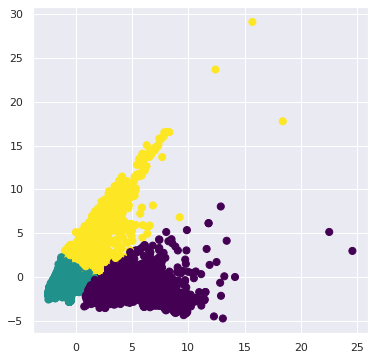

In [93]:
# KMeans
plt.figure(figsize =(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = kmeans.labels_, s = 50, cmap = 'viridis')

In [94]:
# красивый график для KMeans
# for i in range(0, X_pca.shape[0]):
#     if kmeans.labels_[i] == 0:
#         c1 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='r', marker='+')
#     elif kmeans.labels_[i] == 1:
#         c2 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='g', marker='o')
#     elif kmeans.labels_[i] == 2:
#         c3 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='b', marker='*')

# plt.legend([c1, c2, c3], ['Кластер 1', 'Кластер 2', 'Кластер 3'])
# plt.title('knn нашел 3 кластера')
# plt.show()

In [95]:
# sc
# plt.figure(figsize =(6, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c = sc.labels_, s = 50, cmap = 'viridis')

In [96]:
# ac2
# plt.figure(figsize =(6, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c = ac2.labels_, s = 50, cmap = 'viridis')


In [97]:
c = kmeans.labels_
first_class, = np.where(c == 0)
second_class, = np.where(c == 2)
third_class, = np.where(c == 1)


In [98]:
first_class=X_sourse.iloc[first_class,:]
second_class=X_sourse.iloc[second_class,:]
third_class=X_sourse.iloc[third_class,:]

In [99]:
first_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.0,4274.000000,4274.0,4274.0,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4.274000e+03,4274.000000,4274.000000,4.274000e+03,4274.000000,4274.000000,4274.000000,4274.000000
mean,307599.872017,462926.439635,1007.737015,501.489796,4110.119092,4032.599438,0.757604,0.0,0.210576,0.0,1.0,0.995087,0.058727,0.002106,0.995087,0.137810,1.593993e+09,484.501004,37.838325,1.594017e+09,483.995788,18722.084808,6.380020,3.858870
std,217753.877373,191643.531696,1424.191898,211.821248,3114.549947,2925.768762,0.428583,0.0,0.407765,0.0,0.0,0.069932,0.235141,0.045846,0.069932,0.344741,3.641316e+04,155.895246,41.877015,3.219573e+04,155.892838,20735.380944,8.882094,2.371147
min,101000.000000,101000.000000,1.000000,204.450000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,184.828571,1.000000,1.593908e+09,184.000000,207.430000,0.024548,1.270826
25%,115446.000000,344016.500000,333.000000,368.950000,2090.000000,2050.000000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.593964e+09,382.439583,6.000000,1.593991e+09,382.250000,2466.320000,0.373714,2.023552
50%,190005.000000,450104.500000,500.000000,458.205000,3422.500000,3390.000000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.593990e+09,462.920000,20.000000,1.594032e+09,462.000000,10369.650000,1.668620,3.011275
75%,601505.000000,652059.500000,1000.000000,575.920000,5290.000000,5290.000000,1.000000,0.0,0.000000,0.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.594030e+09,534.684370,54.000000,1.594036e+09,534.000000,28007.970000,11.747547,4.967657
max,692922.000000,694920.000000,17950.000000,3658.680000,45350.000000,45350.000000,1.000000,0.0,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.594204e+09,2232.840000,146.000000,1.594204e+09,2232.000000,72182.390000,62.829453,10.000000


In [100]:
second_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,4126.000000,4126.00000,4126.000000,4126.0000,4126.00000,4126.000000,4126.000000,4126.0,4126.000000,4126.0,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4.126000e+03,4126.000000,4126.000000,4.126000e+03,4126.000000,4126.000000,4126.000000,4126.000000
mean,458641.787930,449327.26636,6548.474552,812.4735,390.73873,10.657538,0.902084,0.0,0.026660,0.0,0.337615,0.005817,0.004120,0.014057,0.005817,0.105671,1.594009e+09,729.154275,11.903296,1.594025e+09,728.763694,7487.027392,4.158436,2.475360
std,197736.065839,203596.75370,3900.279732,453.1979,1285.82789,257.264478,0.297237,0.0,0.161108,0.0,0.472954,0.076055,0.064064,0.117741,0.076055,0.307454,3.604819e+04,316.836743,19.706946,2.909835e+04,316.827128,11413.203219,7.966470,1.340480
min,105122.000000,101000.00000,14.000000,179.0000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.593907e+09,306.780000,1.000000,1.593908e+09,306.000000,342.000000,0.014201,0.730662
25%,344010.250000,244671.50000,4118.000000,542.0875,0.00000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594003e+09,535.780000,2.000000,1.594025e+09,535.000000,1534.630000,0.086342,1.616538
50%,453761.000000,446425.50000,5889.000000,682.0000,0.00000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594025e+09,638.000000,5.000000,1.594032e+09,638.000000,3386.600000,0.672771,2.130137
75%,650052.000000,655017.00000,8500.000000,941.0000,100.00000,0.000000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.594031e+09,827.687625,11.000000,1.594035e+09,827.000000,7456.040000,3.103463,2.841535
max,694820.000000,694920.00000,20000.000000,5152.8000,20000.00000,12950.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.594301e+09,5152.800000,146.000000,1.594301e+09,5152.000000,58854.400000,73.281049,9.986778


In [101]:
third_class.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,21600.000000,21600.000000,21600.000000,21600.000000,21600.00000,21600.0,21600.000000,21600.0,21600.000000,21600.0,21600.000000,21600.0,21600.000000,21600.000000,21600.0,21600.000000,2.160000e+04,21600.000000,21600.000000,2.160000e+04,21600.000000,21600.000000,21600.000000,21600.000000
mean,377129.458148,396374.881806,1020.374722,302.072980,52.22287,0.0,0.675741,0.0,0.205926,0.0,0.100648,0.0,0.001389,0.003009,0.0,0.081806,1.593995e+09,321.350073,12.709630,1.594010e+09,321.050046,3953.313618,4.086842,1.197180
std,201605.894124,200571.639100,1184.731302,96.648781,346.64628,0.0,0.468108,0.0,0.404386,0.0,0.300869,0.0,0.037243,0.054775,0.0,0.274075,3.705469e+04,95.242369,25.384604,3.322637e+04,95.182158,7503.708449,7.393007,0.881094
min,101000.000000,101000.000000,0.000000,173.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,0.061976,0.445905
25%,162512.000000,188640.000000,229.000000,238.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593959e+09,260.384590,2.000000,1.593984e+09,260.000000,624.000000,0.177506,0.703994
50%,367014.000000,390044.000000,570.000000,288.000000,0.00000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594009e+09,301.766875,5.000000,1.594028e+09,301.000000,1536.000000,0.447413,0.934286
75%,614056.500000,624221.250000,1210.000000,342.000000,0.00000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594030e+09,372.070000,12.000000,1.594034e+09,372.000000,3964.000000,2.755978,1.391887
max,694910.000000,694923.000000,8974.000000,1200.000000,11000.00000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.594301e+09,825.700000,177.000000,1.594301e+09,825.000000,56467.090000,100.000000,7.042752


In [102]:
third_class_activ=third_class[third_class.activity>1]
third_class_passiv=third_class[third_class.activity<=1]

In [103]:
first_class.describe().loc['count','cost']*first_class.describe().loc['mean','mean_user_cost']

2070757.2903446062

In [104]:
third_class_passiv.describe().loc['count','mean_user_cost']

13299.0

In [105]:
third_class_activ.describe()


,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,8301.000000,8301.000000,8301.000000,8301.000000,8301.000000,8301.0,8301.000000,8301.0,8301.000000,8301.0,8301.000000,8301.0,8301.000000,8301.000000,8301.0,8301.000000,8.301000e+03,8301.000000,8301.000000,8.301000e+03,8301.000000,8301.000000,8301.000000,8301.000000
mean,390834.489218,404077.612095,1016.546561,304.762439,44.688230,0.0,0.758463,0.0,0.178292,0.0,0.097097,0.0,0.000602,0.002048,0.0,0.083966,1.593979e+09,336.391774,23.598723,1.594018e+09,335.989760,7369.455614,10.169079,1.597111
std,205687.634474,203177.419493,1203.136303,98.849617,308.331251,0.0,0.428041,0.0,0.382781,0.0,0.296107,0.0,0.024537,0.045211,0.0,0.277353,3.568012e+04,97.198760,37.034250,3.024940e+04,97.153293,10815.093107,9.059216,1.213134
min,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593907e+09,173.000000,2.000000,1.593916e+09,173.000000,346.000000,1.000421,0.467443
25%,162512.000000,192076.000000,222.000000,260.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593949e+09,272.542500,5.000000,1.594017e+09,272.000000,1710.000000,2.047185,0.885840
50%,390005.000000,394030.000000,567.000000,288.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593967e+09,316.000000,11.000000,1.594032e+09,316.000000,3599.240000,5.542017,1.237087
75%,620144.000000,628260.000000,1200.000000,342.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594022e+09,387.111111,24.000000,1.594035e+09,387.000000,7842.000000,19.437892,1.808926
max,694496.000000,694923.000000,8974.000000,972.000000,10000.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.594056e+09,785.333333,177.000000,1.594301e+09,785.000000,56467.090000,100.000000,7.042752


In [106]:
third_class_passiv.describe()

,sender_index,recipient_index,weight,cost,summa_OTS,summa_NP,blank_dispatch,parcel_post,accelerated,international,with_advert_value,with_imposition_payment,with_list_of_attachments,caution_mark,sms for sender,sms for recipient,ts,mean_user_cost,count_sum,max_data,ts_delta,sum_cost,activity,solvency
count,13299.000000,13299.000000,13299.000000,13299.000000,13299.000000,13299.0,13299.000000,13299.0,13299.000000,13299.0,13299.000000,13299.0,13299.000000,13299.000000,13299.0,13299.000000,1.329900e+04,13299.000000,13299.000000,1.329900e+04,13299.000000,13299.000000,13299.000000,13299.000000
mean,368575.020753,391566.974133,1022.764193,300.394266,56.925859,0.0,0.624107,0.0,0.223175,0.0,0.102865,0.0,0.001880,0.003609,0.0,0.080457,1.594005e+09,311.961310,5.912851,1.594006e+09,311.724942,1821.018354,0.290418,0.947549
std,198544.519896,198784.285786,1173.136048,95.214533,368.481435,0.0,0.484371,0.0,0.416390,0.0,0.303794,0.0,0.043318,0.059971,0.0,0.272010,3.414114e+04,92.776151,8.387624,3.416256e+04,92.722202,2572.260253,0.210777,0.424506
min,101000.000000,101000.000000,0.000000,173.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593907e+09,173.000000,1.000000,1.593907e+09,173.000000,173.000000,0.061976,0.445905
25%,161788.000000,188302.000000,240.000000,238.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.593976e+09,253.500000,1.000000,1.593977e+09,253.000000,400.280000,0.147781,0.656210
50%,360024.000000,385008.000000,580.000000,288.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594025e+09,292.106667,3.000000,1.594026e+09,292.000000,888.000000,0.204469,0.815319
75%,603158.000000,620139.000000,1250.000000,342.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.594032e+09,358.333333,6.000000,1.594033e+09,358.000000,2019.000000,0.357135,1.127467
max,694910.000000,694910.000000,8800.000000,1200.000000,11000.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.594301e+09,825.700000,92.000000,1.594301e+09,825.000000,27398.000000,0.999375,4.325327


In [107]:
df_first=first_class.describe().loc[['mean'],['weight','cost','summa_OTS','summa_NP','count_sum','ts_delta','sum_cost','activity','solvency']]
df_second=second_class.describe().loc[['mean'],['weight','cost','summa_OTS','summa_NP','count_sum','ts_delta','sum_cost','activity','solvency']]
df_third=third_class.describe().loc[['mean'],['weight','cost','summa_OTS','summa_NP','count_sum','ts_delta','sum_cost','activity','solvency']]

In [108]:
df_segment=pd.concat([df_first, df_second, df_third])
df_segment.index = ['first_class', 'second_class', 'third_class']
# cost_segment=df_segment[]

In [109]:
df_segment

,weight,cost,summa_OTS,summa_NP,count_sum,ts_delta,sum_cost,activity,solvency
first_class,1007.737015,501.489796,4110.119092,4032.599438,37.838325,483.995788,18722.084808,6.380020,3.85887
second_class,6548.474552,812.473500,390.738730,10.657538,11.903296,728.763694,7487.027392,4.158436,2.47536
third_class,1020.374722,302.072980,52.222870,0.000000,12.709630,321.050046,3953.313618,4.086842,1.19718


In [110]:
df_first

,weight,cost,summa_OTS,summa_NP,count_sum,ts_delta,sum_cost,activity,solvency
mean,1007.737015,501.489796,4110.119092,4032.599438,37.838325,483.995788,18722.084808,6.38002,3.85887


In [111]:
df_segments.head()

NameError: ignored

In [ ]:
# считаем суммы
# third_class.describe().loc['count','cost']*third_class.describe().loc['mean','sum_cost']

In [ ]:
# sns_plot = sns.distplot(third_class['sum_cost'])
# fig = sns_plot.get_figure()


In [ ]:
df_metrics=first_class.loc[:,['solvency','activity']]
# df_metrics_normalize = preprocessing.MinMaxScaler(df_metrics)
df_metrics_normalize= preprocessing.scale(df_metrics)

In [ ]:
df_metrics.head()


In [ ]:
df_metrics_normalize

In [ ]:
sns_plot = sns.distplot(third_class['ts_delta'])
fig = sns_plot.get_figure()

In [ ]:
# sns_plot = sns.distplot(df_metrics_normalize[:,1])
# fig = sns_plot.get_figure()

In [ ]:
# распределение активности и платежеспособности 
# plt.figure(figsize =(6, 6))
# plt.scatter(df_metrics_normalize[:,1], df_metrics_normalize[:,0], s = 50, cmap = 'viridis', )

In [ ]:
first_class.to_csv('first_class.csv')
second_class.to_csv('second_class.csv')
third_class.to_csv('third_class.csv')